# Assignment 3

1. Implement Logistic Regression with Stochastic Gradient Decent using numpy
1. Implement Logistic Regression with early stopping using pytorch

Additional readings:
1. https://www.pythonlikeyoumeanit.com/Module3_IntroducingNumpy/VectorizedOperations.html
1. https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

In [224]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_20newsgroups
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from ipywidgets import IntProgress

# retrieve dataset
data = fetch_20newsgroups()


X_train = data['data']
y_train = data['target']

tfidf = TfidfVectorizer(max_df=0.5, min_df=10)
X_train = tfidf.fit_transform(X_train)

test_data = fetch_20newsgroups(subset='test')
X_test = tfidf.transform(test_data['data'])
y_test = test_data['target']

## 1 Binary Logistic Regression
$\{(x_i, y_i)\}_{i=1}^N$, $y \in \{0,1\}$
$$ z = Xw + b $$

$$p(y=1 | x) = \sigma(z) = \frac 1 {1 + e^{-z}}$$

$$ L_{batch} = - \frac 1 {|batch|} \sum_{i \in batch}^N [ y_i \log \sigma(z_i) + (1 - y_i) \log (1 - \sigma(z_i)) ] + \frac \lambda 2 w^T w$$

Stochastic Gradient Decent for logreg:
1. init w ~ random N(0,1), b = 0
1. for epoch = 1..n_epochs:
    * shuffle dataset
    * for every batch:
        * $w^{(t)} \leftarrow w^{(t-1)} - \alpha \nabla_{w} L_{batch}(w^{(t-1)},b^{(t-1)})$
        * $b^{(t)} \leftarrow b^{(t-1)} - \alpha \nabla_{b} L_{batch}(w^{(t-1)},b^{(t-1)})$
        
$w$ - weights  
$b$ - biases  
$\alpha$ - learning rate

Hint:
$$\nabla_w L = \frac {\partial L} {\partial \sigma} \frac {\partial \sigma} {\partial z} \frac {\partial z} {\partial w} + \frac {\partial (\frac \lambda 2 w^T w)} {\partial w} $$
$$\nabla_b L = \frac {\partial L} {\partial \sigma} \frac {\partial \sigma} {\partial z} \frac {\partial z} {\partial b} $$

In [225]:
# make dataset for binary classification

X_train_bin = X_train[y_train < 2]
y_train_bin = y_train[y_train < 2]

X_test_bin = X_test[y_test < 2]
y_test_bin = y_test[y_test < 2]

y_train_bin.shape, y_test_bin.shape

((1064,), (708,))

auc 0.9963575118259986


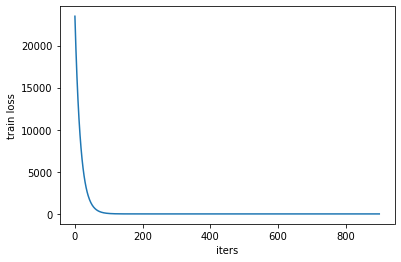

In [226]:
class LogRegNumpy(ClassifierMixin):
    def __init__(self, llambda=1, lr=0.1, batch_size=32, n_epochs=100):
        """
        llambda: regularization strength
        lr: learning rate
        """
        self.w = None
        self.b = 0
        self.llambda = llambda
        self.n_epochs = n_epochs
        self.lr = lr
        self.history = []
        self.batch_size = batch_size
        
    @staticmethod
    def sigmoid(pred):
        return 1.0 / (1 + np.exp(-pred))
    
    def calculate_loss(self, y_pred, batch_X, batch_y):
        loss = -batch_y * np.log(y_pred) - (1 - batch_y) * np.log(1 - y_pred)
        return loss.sum() / batch_X.shape[0] + (self.llambda / 2) * self.w.T.dot(self.w)
        
    def fit(self, X, y):
        np.random.seed(42)
        self.w = np.random.randn(X.shape[1])
        self.b = 0
        
        for epoch in range(self.n_epochs):
            
            # random permutation over indices of dataset
            batch_indices = np.random.permutation(len(y))
            
            for j in range(0, len(y), self.batch_size):
                batch_idx = batch_indices[j:j + self.batch_size]
                batch_X = X[batch_idx]
                batch_y = y[batch_idx]
                
                y_pred = self.predict_proba(batch_X)
            
                # forward pass
                # <TODO> [1 point] calculate batch loss
                loss = self.calculate_loss(y_pred, batch_X, batch_y)
                dy = y_pred - batch_y
                
                # backward pass
                # <TODO> [2 points] calculate batch gradients 
                grad_w = (1 / batch_X.shape[1]) * batch_X.T.dot(dy) + self.llambda * self.w
                grad_b = (1 / batch_X.shape[1]) * np.sum(dy)

                # SGD optimization step
                # <TODO> [1 point]
                self.w -= self.lr * grad_w
                self.b -= self.lr * grad_b

                self.history.append(loss)
        
        return self 
    
    def predict_proba(self, X):
        # <TODO> [1 point] calculate p(y=1 | x)
        pred = X.dot(self.w) + self.b
        return self.sigmoid(pred)
    
    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(np.int)
    
    
model = LogRegNumpy(llambda=3, lr=0.01, batch_size=128, n_epochs=100)
model.fit(X_train_bin, y_train_bin)
print('auc', metrics.roc_auc_score(y_test_bin, model.predict_proba(X_test_bin)))

plt.plot(np.arange(len(model.history)), model.history)
plt.xlabel('iters')
plt.ylabel('train loss');

# Multinomial Logistic Regression using pytorch

In [227]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

###  [1 point] implement linear model $Z = XW + b$

In [228]:
class LogRegNN(nn.Module):
    
    def __init__(self, n_features, n_classes):
        super(LogRegNN, self).__init__()
        
        # create tensor of weights and tensor of biases
        # initialize tensors from N(0,1) 
        # W has shape (n_features, n_classes)
        # b has shape (n_classes,)
        self.W = nn.Parameter(torch.randn(n_features, n_classes))
        self.b = nn.Parameter(torch.randn(n_classes))
        
    def forward(self, x):
        """
        In this method we implement connections between neural network weights
        x: batch feature matrix
        returns: probability logits
        """
        # <TODO> implement linear model 
        result = x @ self.W + self.b
        return result

In [229]:
def train_batch(model, batch_x, batch_y):
    # set NN model in training mode
    model.train()
    
    # zero gradients
    optimizer.zero_grad()
    # forward pass
    pred = model(batch_x)
    # cross-entropy loss
    loss = criterion(pred, batch_y)
    # calculate gradients
    loss.backward()
    # make optimization step
    optimizer.step()
    
    # return batch loss
    return loss.data.detach().item()

def eval_batch(model, batch_x, batch_y):
    # set NN model in evaluation mode
    model.eval()
    
    with torch.no_grad():
        # forward pass
        pred = model(batch_x)
        # cross-entropy loss
        loss = criterion(pred, batch_y)

    # return batch loss
    return loss.data.item()

### [2 points] implement early stopping using early_stopping_patience

In [230]:
class EarlyStopping:
    def __init__(self, early_stopping_patience=5):
        self.early_stopping_patience = early_stopping_patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.early_stopping_patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [231]:
def train(model, train_loader, valid_loader, n_epochs, early_stopping_patience=5):
    """
    early_stopping_patience - number of consecutive epochs of growing validation loss to wait
    """
    history = {'train': [], 'valid': []}

    # <TODO> implement early stopping using early_stopping_patience
    early_stopping = EarlyStopping(early_stopping_patience=early_stopping_patience)
    
    for epoch in range(n_epochs):
        epoch_train_loss = 0
        
        # iterate over batches
        for batch_x, batch_y in tqdm(train_loader, desc=f'epoch:{epoch}', leave=True):

            loss = train_batch(model, batch_x, batch_y)
            epoch_train_loss += loss

        # average loss for epoch
        epoch_train_loss /= len(train_loader)
        history['train'].append(epoch_train_loss)
        
        epoch_valid_loss = 0
        for batch_x, batch_y in valid_loader:
            loss = eval_batch(model, batch_x, batch_y)
            epoch_valid_loss += loss
            
        epoch_valid_loss /= len(valid_loader)
        print(f'train loss: {epoch_train_loss:.3f} valid loss:{epoch_valid_loss:.3f}')
        history['valid'].append(epoch_valid_loss)
        
        # <TODO> implement early stopping using early_stopping_patience
        early_stopping(epoch_valid_loss)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

    return history 

### predict hard labels [1 point]

In [232]:
def predict(model, test_loader):
    
    model.eval()
    
    result = []
    with torch.no_grad():
        for batch_x in test_loader:
            # <TODO> predict hard labels
            pred = model.forward(batch_x)
            soft_pred = torch.nn.functional.softmax(pred)
            result.append(np.argmax(soft_pred, axis=1))
    return np.concatenate(result)

DataLoader implements iteration over batches and shuffling

L2 regularization coef is embedded into SGD.weight_decay: 

1. $w^{(t-1)} \leftarrow w^{(t-2)} - \alpha \lambda w^{(t-2)} $  
1. $w^{(t)} \leftarrow w^{(t-1)} - \alpha \nabla_{w} L(w^{(t-1)}) $

here   
$\alpha$ - learning rate  
$\lambda$ - weight-decay = L2 regularization coef

In [233]:
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X_train, y_train, stratify=y_train,
                                                      shuffle=True, test_size=0.2, random_state=42)

batch_size = 256


train_loader = DataLoader(TensorDataset(torch.tensor(X_train2.todense()).float(), torch.tensor(y_train2).long()), 
                          batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(torch.tensor(X_valid2.todense()).float(), torch.tensor(y_valid2).long()), 
                          batch_size=batch_size)
test_loader = DataLoader(torch.tensor(X_test.todense()).float(), 
                          batch_size=batch_size)

model = LogRegNN(X_train.shape[1], 20)

criterion = nn.CrossEntropyLoss()
# L2 regularization is embeded in 
optimizer = optim.SGD(model.parameters(), lr=10, weight_decay=0.00001)

history = train(model, train_loader, valid_loader, 500, 2)

train loss: 3.334 valid loss:3.111


train loss: 2.902 valid loss:2.768


train loss: 2.546 valid loss:2.487


train loss: 2.256 valid loss:2.239


train loss: 2.008 valid loss:2.040


train loss: 1.804 valid loss:1.874


train loss: 1.635 valid loss:1.744


train loss: 1.496 valid loss:1.621


train loss: 1.374 valid loss:1.535


train loss: 1.273 valid loss:1.447


train loss: 1.185 valid loss:1.376


train loss: 1.108 valid loss:1.311


train loss: 1.042 valid loss:1.257


train loss: 0.985 valid loss:1.212


train loss: 0.932 valid loss:1.160


train loss: 0.883 valid loss:1.127


train loss: 0.842 valid loss:1.089


train loss: 0.804 valid loss:1.058


train loss: 0.770 valid loss:1.031


train loss: 0.735 valid loss:1.001


train loss: 0.705 valid loss:0.976


train loss: 0.678 valid loss:0.955


train loss: 0.651 valid loss:0.937


train loss: 0.632 valid loss:0.914


train loss: 0.609 valid loss:0.899


train loss: 0.591 valid loss:0.881


train loss: 0.570 valid loss:0.864


train loss: 0.555 valid loss:0.851


train loss: 0.536 valid loss:0.836


train loss: 0.521 valid loss:0.822


train loss: 0.505 valid loss:0.811


train loss: 0.492 valid loss:0.801


train loss: 0.480 valid loss:0.790


train loss: 0.468 valid loss:0.778


train loss: 0.455 valid loss:0.769


train loss: 0.443 valid loss:0.760


train loss: 0.435 valid loss:0.753


train loss: 0.423 valid loss:0.744


train loss: 0.413 valid loss:0.734


train loss: 0.404 valid loss:0.727


train loss: 0.398 valid loss:0.722


train loss: 0.389 valid loss:0.719


train loss: 0.379 valid loss:0.706


train loss: 0.373 valid loss:0.700


train loss: 0.366 valid loss:0.695


train loss: 0.359 valid loss:0.691


train loss: 0.350 valid loss:0.683


train loss: 0.344 valid loss:0.679


train loss: 0.338 valid loss:0.674


train loss: 0.333 valid loss:0.671


train loss: 0.326 valid loss:0.664


train loss: 0.322 valid loss:0.659


train loss: 0.316 valid loss:0.659


train loss: 0.311 valid loss:0.652


train loss: 0.306 valid loss:0.646


train loss: 0.302 valid loss:0.645


train loss: 0.295 valid loss:0.643


train loss: 0.292 valid loss:0.635


train loss: 0.289 valid loss:0.632


train loss: 0.283 valid loss:0.629


train loss: 0.279 valid loss:0.625


train loss: 0.275 valid loss:0.623


train loss: 0.272 valid loss:0.618


train loss: 0.267 valid loss:0.617


train loss: 0.265 valid loss:0.616


train loss: 0.262 valid loss:0.614


train loss: 0.258 valid loss:0.608


train loss: 0.255 valid loss:0.606


train loss: 0.251 valid loss:0.603


train loss: 0.248 valid loss:0.602


train loss: 0.246 valid loss:0.600


train loss: 0.243 valid loss:0.595


train loss: 0.240 valid loss:0.594


train loss: 0.239 valid loss:0.590


train loss: 0.234 valid loss:0.589


train loss: 0.232 valid loss:0.587


train loss: 0.229 valid loss:0.584


train loss: 0.227 valid loss:0.583


train loss: 0.225 valid loss:0.582


train loss: 0.223 valid loss:0.579


train loss: 0.220 valid loss:0.577


train loss: 0.218 valid loss:0.576


train loss: 0.215 valid loss:0.574


train loss: 0.215 valid loss:0.574


train loss: 0.212 valid loss:0.572


train loss: 0.211 valid loss:0.570


train loss: 0.208 valid loss:0.567


train loss: 0.206 valid loss:0.565


train loss: 0.204 valid loss:0.565


train loss: 0.203 valid loss:0.564


train loss: 0.200 valid loss:0.561


train loss: 0.199 valid loss:0.560


train loss: 0.197 valid loss:0.559


train loss: 0.197 valid loss:0.557


train loss: 0.194 valid loss:0.556


train loss: 0.193 valid loss:0.555


train loss: 0.192 valid loss:0.556


train loss: 0.191 valid loss:0.553


train loss: 0.190 valid loss:0.550


train loss: 0.188 valid loss:0.550


train loss: 0.187 valid loss:0.549


train loss: 0.186 valid loss:0.548


train loss: 0.184 valid loss:0.547


train loss: 0.183 valid loss:0.545


train loss: 0.181 valid loss:0.544


train loss: 0.180 valid loss:0.544


train loss: 0.179 valid loss:0.541


train loss: 0.178 valid loss:0.541


train loss: 0.177 valid loss:0.540


train loss: 0.176 valid loss:0.539


train loss: 0.175 valid loss:0.539


train loss: 0.174 valid loss:0.538


train loss: 0.173 valid loss:0.537


train loss: 0.172 valid loss:0.537


train loss: 0.171 valid loss:0.535


train loss: 0.169 valid loss:0.534


train loss: 0.169 valid loss:0.533


train loss: 0.167 valid loss:0.533


train loss: 0.167 valid loss:0.532


train loss: 0.166 valid loss:0.531


train loss: 0.165 valid loss:0.530


train loss: 0.165 valid loss:0.529


train loss: 0.164 valid loss:0.528


train loss: 0.163 valid loss:0.528


train loss: 0.161 valid loss:0.528


train loss: 0.162 valid loss:0.527


train loss: 0.161 valid loss:0.528


train loss: 0.161 valid loss:0.525


train loss: 0.159 valid loss:0.524


train loss: 0.159 valid loss:0.526


train loss: 0.158 valid loss:0.524


train loss: 0.157 valid loss:0.522


train loss: 0.156 valid loss:0.523


train loss: 0.156 valid loss:0.522


train loss: 0.155 valid loss:0.522


train loss: 0.155 valid loss:0.521


train loss: 0.155 valid loss:0.520


train loss: 0.154 valid loss:0.520


train loss: 0.153 valid loss:0.519


train loss: 0.152 valid loss:0.518


train loss: 0.151 valid loss:0.518


train loss: 0.152 valid loss:0.519
Early stopping


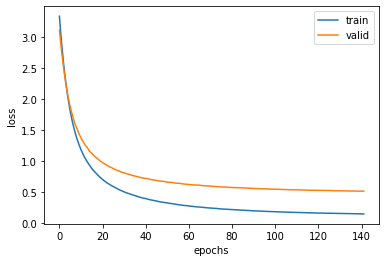

In [234]:
plt.plot(np.arange(len(history['train'])), history['train'], label='train')
plt.plot(np.arange(len(history['valid'])), history['valid'], label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [235]:
y_pred = predict(model, test_loader)
metrics.accuracy_score(y_test, y_pred)

/home/valeria/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


0.7951407328730749

### What is the cross-entropy loss of uniformly random guessing classifier for this task? [0.5 point]

In [308]:
randommed_y_pred = np.random.uniform(0, 1, (7532, 20))
criterion( torch.tensor(randommed_y_pred), torch.tensor(y_test))

tensor(3.0370, dtype=torch.float64)

### What is the accuracy of constant prediction classifier for this task? [0.5 point]

In [309]:
metrics.accuracy_score(y_test, [1] * len(y_test))

0.05164630908125332